In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set plot style
sns.set_style("whitegrid")
pd.set_option("display.max_columns", 50)

# Load the dataset
try:
    df = pd.read_json("/mnt/c/Users/moham/8_churn/data/customer_churn.json", lines=True)
    df_logged_in = df[df["auth"] == "Logged In"].copy()
    df_logged_in["ts"] = pd.to_datetime(df_logged_in["ts"], unit="ms")
    print("Dataset loaded and preprocessed.")
except FileNotFoundError:
    print("Error: Dataset not found.")

Dataset loaded and preprocessed.


In [5]:
# To define inactivity, we must know the timeframe of our data.
min_date = df_logged_in["ts"].min()
max_date = df_logged_in["ts"].max()

print(f"Data ranges from: {min_date} to {max_date}")
print(f"Total duration: {(max_date - min_date).days} days")

# We'll define "recent inactivity" based on this. Let's assume a user is inactive
# if their last action was more than 30 days before the last record in the dataset.
INACTIVITY_THRESHOLD = pd.Timedelta(days=30)

Data ranges from: 2018-10-01 00:00:11 to 2018-12-01 00:01:06
Total duration: 61 days


In [6]:
# We'll consider 'Submit Downgrade' and 'Thumbs Down' as triggers.
downgrade_users = df_logged_in[df_logged_in["page"] == "Submit Downgrade"][
    "userId"
].unique()
thumbs_down_users = df_logged_in[df_logged_in["page"] == "Thumbs Down"][
    "userId"
].unique()

potential_churners = np.union1d(downgrade_users, thumbs_down_users)
print(f"Found {len(potential_churners)} users who have shown churn-trigger behavior.")

Found 390 users who have shown churn-trigger behavior.


In [7]:
# Get the last interaction timestamp for every user
last_interaction = df_logged_in.groupby("userId")["ts"].max()

# Filter for users who showed churn-trigger behavior
potential_churn_last_interaction = last_interaction[
    last_interaction.index.isin(potential_churners)
]

# A user has churned if their last interaction was before our inactivity cutoff
cutoff_date = max_date - INACTIVITY_THRESHOLD
churned_user_ids = potential_churn_last_interaction[
    potential_churn_last_interaction < cutoff_date
].index

print(
    f"Identified {len(churned_user_ids)} churned users based on triggers and subsequent inactivity."
)

# Create the final churn label
user_level_df = pd.DataFrame(df_logged_in["userId"].unique(), columns=["userId"])
user_level_df["churn"] = user_level_df["userId"].isin(churned_user_ids).astype(int)

Identified 46 churned users based on triggers and subsequent inactivity.


New Churn distribution at user level:
churn
0    402
1     46
Name: count, dtype: int64

New overall churn rate: 10.27%


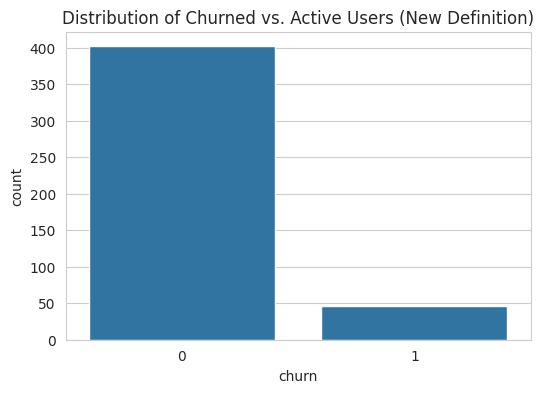

In [8]:
churn_distribution = user_level_df["churn"].value_counts()
churn_rate = user_level_df["churn"].value_counts(normalize=True).get(1, 0)

print("New Churn distribution at user level:")
print(churn_distribution)
print(f"\nNew overall churn rate: {churn_rate:.2%}")

# Visualize the new distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="churn", data=user_level_df)
plt.title("Distribution of Churned vs. Active Users (New Definition)")
plt.show()